In [2]:
%load_ext autoreload

In [3]:
%autoreload
import os
os.chdir(os.path.expanduser("/notebooks/segmentation"))
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F

from PIL import Image
import PIL

from train_utils.utils import mIoU, Lion, Dice
from plotter.plot import plot_prediction
from train_utils.unet_pipeline_trainer import train

from batchflow import batchflow as bf
from batchflow.batchflow import B, M, V, C, Notifier, Pipeline, Dataset
from batchflow.batchflow.models.torch.unet import UNet as Unet_bf
from batchflow.batchflow.opensets.ade import ADESegmentation

import warnings
warnings.filterwarnings("ignore")

In [9]:
train_params = {
    'BATCH_SIZE': 32,
    'LR': 1e-4,
    'NUM_CLASSES': 151,
    'NUM_EPOCHS': 90,
    'IMAGE_SHAPE': (256, 256)
}

In [5]:
dataset = ADESegmentation()
dataset.split([0.7, 0.2, 0.1], shuffle=True)

ADEChallengeData2016.zip: 944710KB [01:00, 15496.39KB/s]                            


In [6]:
config = Unet_bf.default_config()

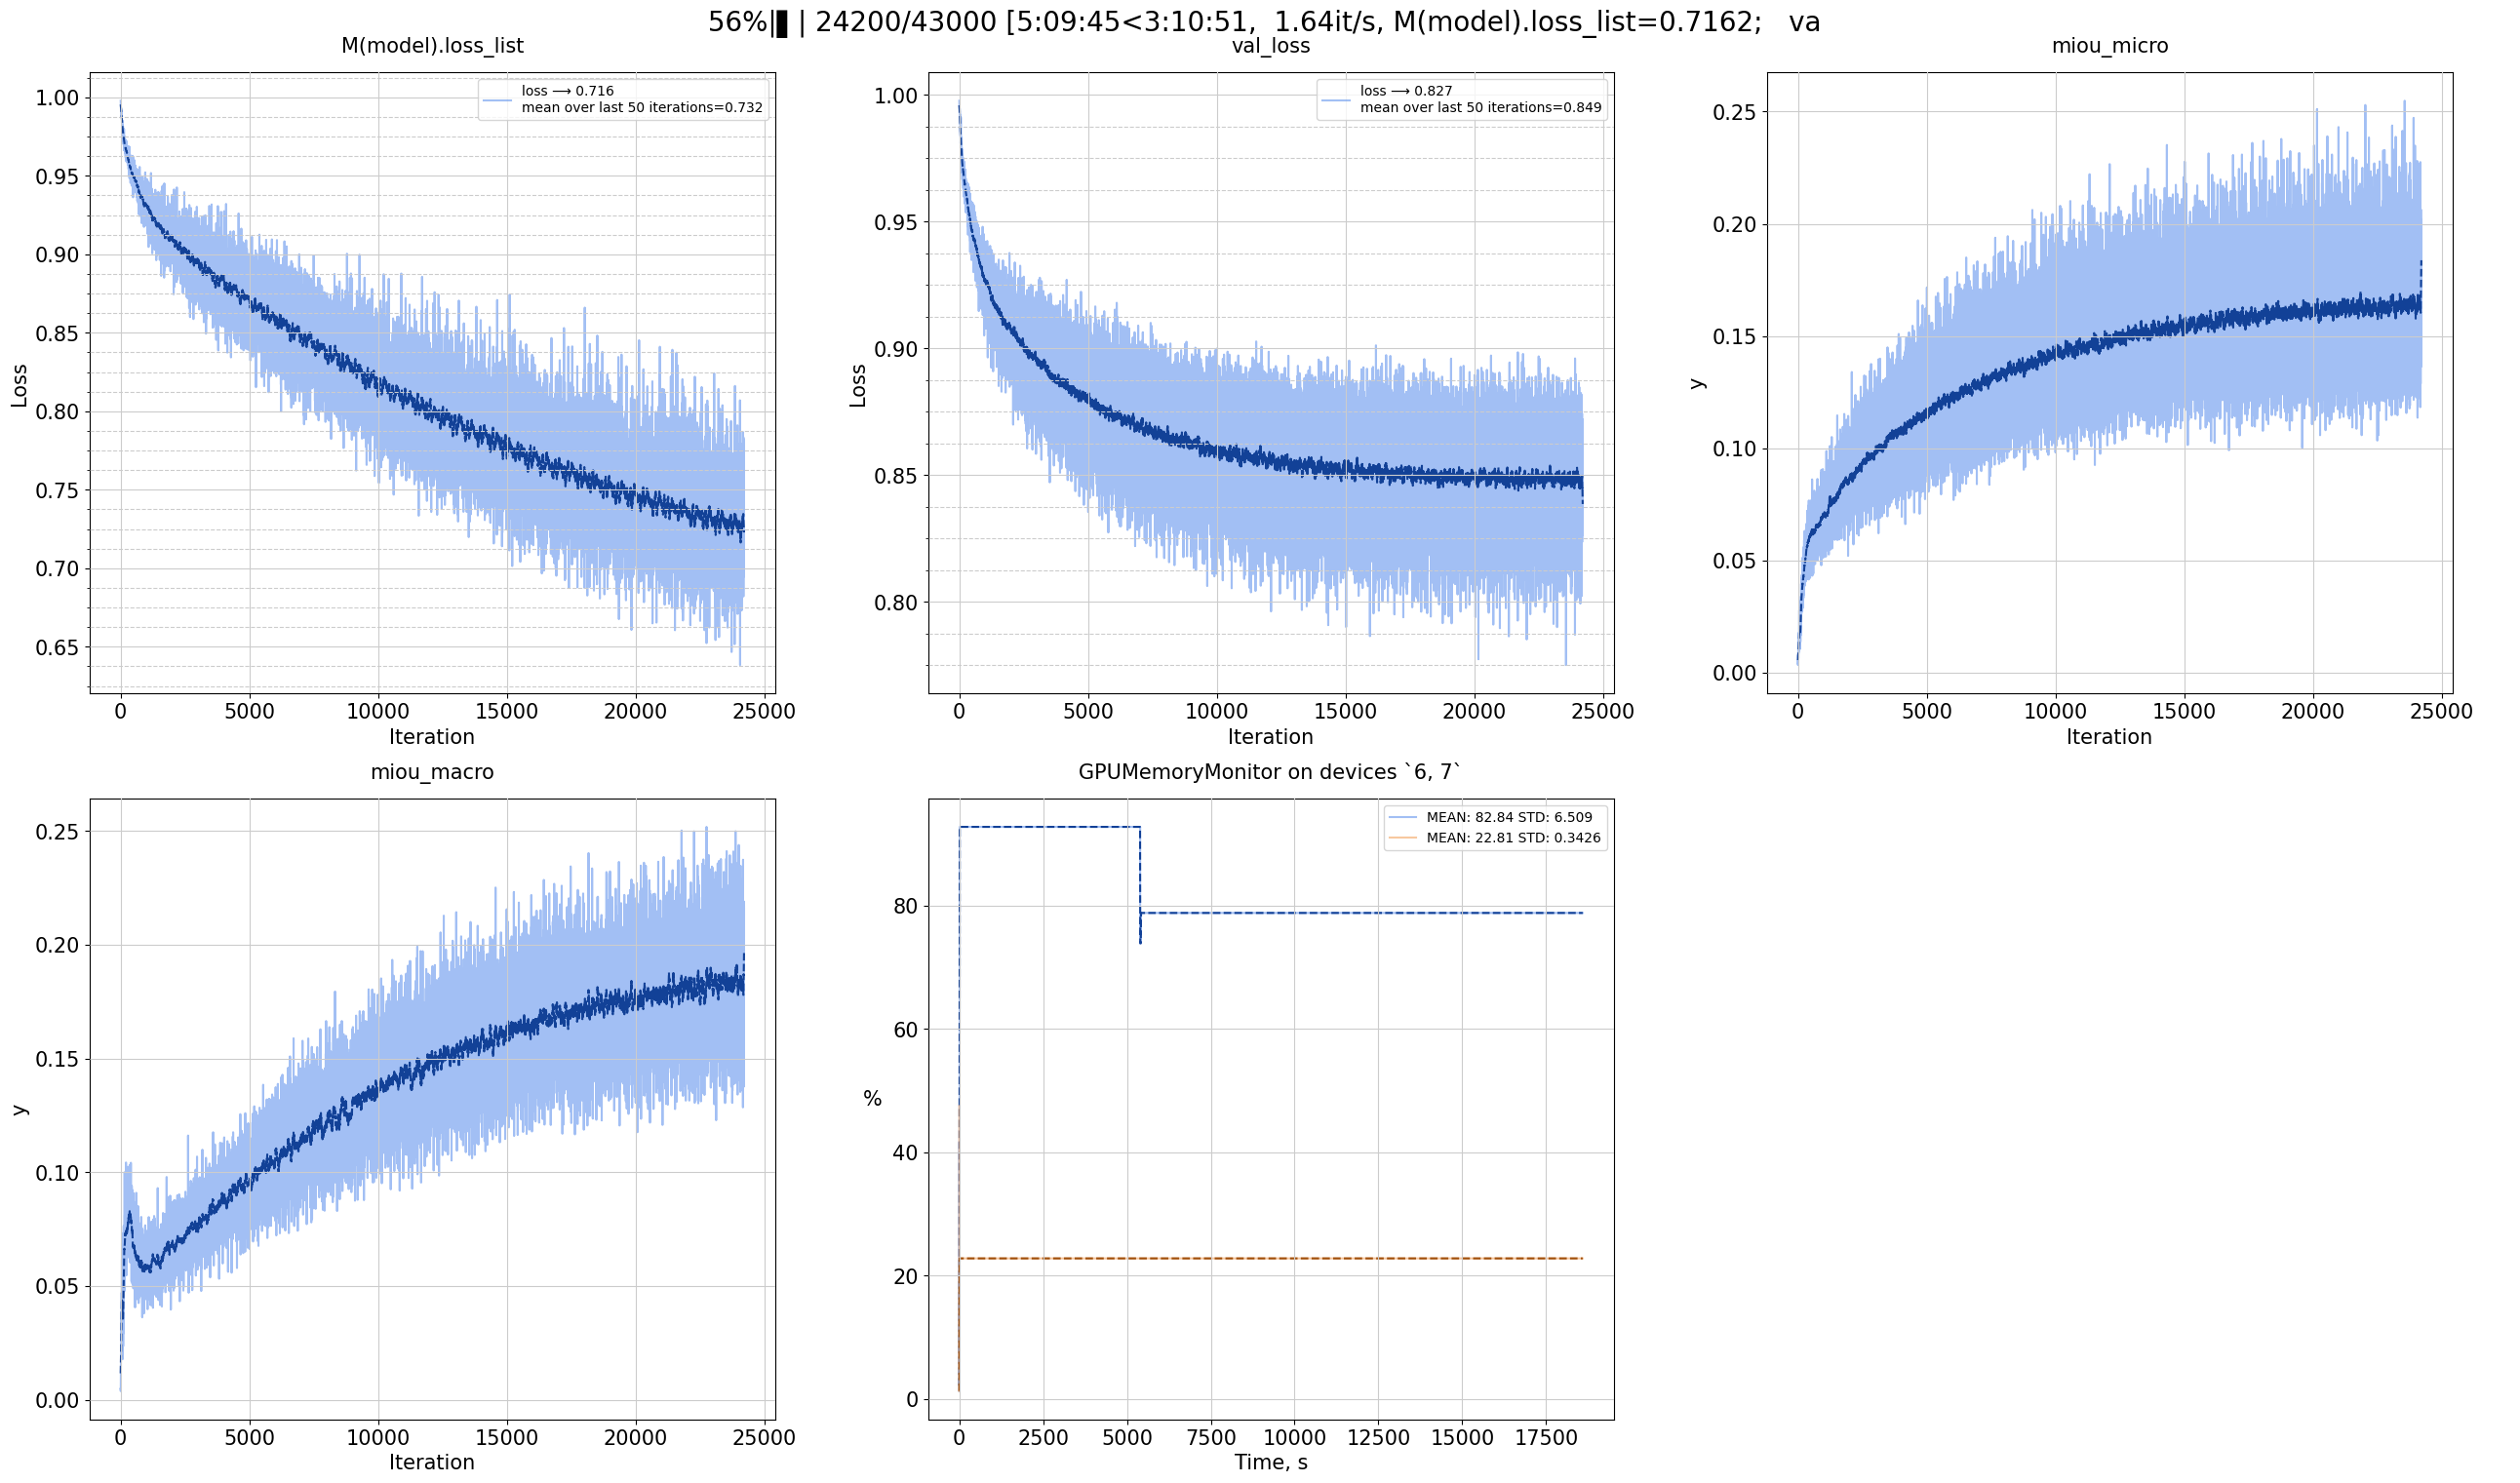

In [ ]:
train_val_pipeline = train(
    dataset=dataset,
    config=config,
    loss=Dice,
    optimizer={'name': Lion, 'lr': train_params['LR']},
    train_params=train_params,
    n_iters=43000,
    visible_devices='6,7',
    frequency=100
)

In [10]:
test_pipeline = (
    Pipeline()
    .import_model('model', train_val_pipeline)
    .init_variable('images', [])
    .init_variable('predictions', [])
    .init_variable('masks', [])
    .init_variable('iou', [])

    .resize(size=train_params['IMAGE_SHAPE'], resample=Image.Resampling.BILINEAR, src='images', dst='images')
    .to_array(channels='first', dtype=np.float32, src='images', dst='images')

    .resize(size=train_params['IMAGE_SHAPE'], resample=Image.Resampling.NEAREST, src='labels', dst='masks')
    .to_array(channels='first', dtype=np.int64, src='masks', dst='masks')

    .predict_model('model', inputs=B.images,
                   outputs='predictions', save_to=V('predictions', mode='a'))
    .update(V('images', mode='a'), B.images)
    .update(V('masks', mode='a'), B.masks)
    .mIoU(preds=V.predictions[-1], mask=B('masks'), num_classes=train_params['NUM_CLASSES'], save_to=V('iou', mode='a'))
) << ds.test

test_pipeline = test_pipeline.run(batch_size=1, shuffle=False, n_epochs=1, drop_last=False, bar=True)

NameError: name 'train_val_pipeline' is not defined

In [ ]:
plot_prediction(pipeline=test_pipeline, alpha=0.6, image_number=0, dataset='ADE')